## Part 1 - Exploratory Data Analysis

### 1.0. Libraries and data files
***

In [2]:
!apt-get update
# importing the necessary spark environment and getting jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://www-us.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop2.7'

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [3]:
# getting the data
!pip install -q wget
!pip install -q findspark
import wget
data_19 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_19_players.csv'
data_21 = 'https://raw.githubusercontent.com/Gooner12/FIFA_2019/main/FIFA_21_players.csv'
dataset_19 = wget.download(data_19)
dataset_21 = wget.download(data_21)

In [4]:
import findspark
findspark.init()
#findspark.find()
from pyspark.sql import SparkSession

### 1.1 Data Exploration
***

In [5]:
# importing the 'FIFA_19.csv' as a Spark dataframe
spark = SparkSession.builder.appName('FIFA_19').config('spark.sql.caseSensitive', 'true').getOrCreate()
sc = spark.sparkContext
# not including header as data while reading so the header value is made true
df_19 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_19_players.csv')
df_19.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work Rate| Body 

In [6]:
df_21 = spark.read.format('csv').options(header='true', inferschema='true').load('FIFA_21_players.csv')
df_21.show()

+---------+--------------------+-----------------+--------------------+---+----------+---------+---------+-----------+-------------------+--------------------+-----------+-------+---------+---------+--------+----------------+--------------+------------------------+---------+-----------+-------------+--------------------+---------+------------------+--------------------+-------------+------------------+-----------+----------+--------------------+---------------+--------------------+----+--------+-------+---------+---------+------+---------+-----------+----------+-----------+--------+--------------+--------------------+------------------+-------------------+--------------------------+-----------------------+-----------------+---------------+-----------+-----------------+------------------+------------------+---------------------+---------------------+----------------+------------------+----------------+----------------+-------------+-------------+--------------+----------------+---------

Merging the 2019 and 2021 dataframe to get the overall, potential, value in 2021 for every player.

In [7]:
# first renaming the id column in fifa 21 database same as the id column in fifa 19 database for merging later
df_21 = df_21.withColumnRenamed('sofifa_id','ID')
# joining the two dataframes on id and only merging overall, potential and value_eur to the fifa 19 database
df = df_19.join(df_21['ID','overall','potential','value_eur'], on=['ID'], how='left_outer')
df.cache()
df.show()

+------+-----------------+---+--------------------+-----------+--------------------+-------+---------+-------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall|Potential|               Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill

In [8]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- value(M): string (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)
 |-- Contract 

Dealing Missing Values:

In this stage, we examine the dataset to see the necessary operations required on data to ease our analysis. Based on the examination, we develop separate transformers that can perform data manipulation to output the data in a desired format.

In [9]:
# checking the missing values
from pyspark.sql.functions import count, col, when
from pyspark.sql import functions as F
null_values_count = df.select([count(when(F.isnull(cols), cols)).alias(cols) for cols in df.columns])
null_values_count.show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

In this analysis, the attributes that we are concerned with are player attributes that has impacts on players' gameplay such as 'Crossing', ShortPassing', etc. We are only concerned with forwards, midfielders and defenders not goalkeepers. It is seen that all attributes of interests have 48 missing values which include goalkeeping attributes too. So, we need to see if those missing values for different attributes belong to goalkeepers only before performing imputation or deletion of missing values.

In [10]:
# checking the missing values after removing goalkeepers
df_non_goalkeeper = df.filter(df['Position'] != 'GK')
df_non_goalkeeper.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in df.columns]).show()

+---+----+---+-----+-----------+----+-------+---------+----+---------+--------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
| ID|Name|Age|Photo|Nationality|Flag|Overall|Potential|Club|Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Until|Height|Height(CM)|Weight|Weight(KG)|Crossing|Finishing|Hea

It is seen that no missing values are present in our many attributes of interests for players belonging to positions other than goalkeepers. Important features in our analysis such as value(M), potential and value_eur, still have missing values, so appropriate operations to deal with those missing values should be performed before we proceed to other analysis.

Handling of missing values in Value_2019(M) column:

In [11]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

#df_view = 'soccer_analysis'
df.createOrReplaceTempView('soccer_analysis')

In [12]:
spark.sql("""
          Select * from soccer_analysis Where value_eur Is Not Null AND `value(M)` Is Null
          """).show()

+------+-------------+---+--------------------+------------+--------------------+-------+---------+---------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+-----------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo| Nationality|                Flag|Overall|Potential|           Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|     Work

It is seen that although we have missing values for players value in 2019, we can find the value of some of those players in 2021. Based on the value in 2021, we perform imputation of missing values in value column in 2019. To do that, we first compare the values in both years and calculate the percentage variation in values in those two years. Using that variation, we calculate the figures for missing values. 

The necessary operation is performed in a separate python file which we will import later.

In [13]:
spark.sql("""
          Select * from soccer_analysis Where `value(M)` Like '%K'
          """).show()

+------+-------------+---+--------------------+--------------+--------------------+-------+---------+--------------------+--------------------+--------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+-------+---------+---------+
|    ID|         Name|Age|               Photo|   Nationality|                Flag|Overall|Potential|                Club|           Club Logo|value(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill 

All the issues seen above have to be dealt before proceeding to further analysis. To deal with those issues, a separate python script has been developed which we will import later on in this analysis to create dataframes that are free from complications seen above.

Creating Pipelines for Data Preprocessing:

In this stage, we create a pipelines for the regression task. 

Note: the modules used to generate the regression dataframe can be found in the github repository for this project.

Here, we import two python scripts containing transformers that we developed according to our examination in the previous section. The first python script is data_preprocessor.py which contains classes such as ValueManipulator, UnifyValue and ValueImputer. The second script is target_generator, and it contains classes such as ProfitGenerator and GrowthGenerator.

In [14]:
!rm -rf FIFA_2019

In [15]:
# only for google colab
!git clone https://github.com/Gooner12/FIFA_2019.git FIFA_2019
!mv "/content/FIFA_2019/data_preprocessor.py" "/content/"
!mv "/content/FIFA_2019/target_generator.py" "/content/"
!mv "/content/FIFA_2019/encoder.py" "/content/"

Cloning into 'FIFA_2019'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 243 (delta 134), reused 168 (delta 90), pack-reused 0
Receiving objects: 100% (243/243), 4.95 MiB | 10.13 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [16]:
from pyspark.ml import Pipeline
import data_preprocessor, target_generator

# defining the stage that changes the units of players' values in 2021 along with renaming columns based on the year 
value_manipulation = data_preprocessor.ValueManipulator()
# defining the stage that standardises the players' values in 2019 to millions
value_standardisation = data_preprocessor.UnifyValue()
# defining the stage that imputes and removes missing values present in players' values in 2019 and 2021
value_imputation = data_preprocessor.ValueImputer()
# defining the stage that generates labels based on profits in two years for regression
regression_target = target_generator.ProfitGenerator()
# defining the stage that generates labels based on the potential to grow in two years
classification_target = target_generator.GrowthGenerator()

DataFrame for Regression:

In [17]:
# creating a pipeline to generate dataframe for regression
pipeline_regression = Pipeline(stages=[value_manipulation, value_standardisation, value_imputation, regression_target])
# fitting the pipeline model and transforming the data as defined
pipeline_model = pipeline_regression.fit(df)
regression_df = pipeline_model.transform(df)

In [18]:
regression_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall_2019: integer (nullable = true)
 |-- Potential_2019: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value_2019(M): double (nullable = true)
 |-- wage(K): integer (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Preferred Foot: string (nullable = true)
 |-- International Reputation: integer (nullable = true)
 |-- Weak Foot: integer (nullable = true)
 |-- Skill Moves: integer (nullable = true)
 |-- Work Rate: string (nullable = true)
 |-- Body Type: string (nullable = true)
 |-- Real Face: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Jersey Number: integer (nullable = true)
 |-- Joined: string (nullable = true)
 |-- Loaned From: string (nullable = true)

In [19]:
regression_df.show(5)

+------+-----------------+---+--------------------+-----------+--------------------+------------+--------------+-------------------+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+----------+---------+--------+-------------+------------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
|    ID|             Name|Age|               Photo|Nationality|                Flag|Overall_2019|Potential_2019|               Club|           Club Logo|Value_2019(M)|wage(K)|S

In [20]:
# checking the missing values in regression dataframe
regression_df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in regression_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Un

It is seen that the column wage has 89 missing values, and this column might be important in predicting the players' price. 

In [21]:
# creating a view
regression_df.createOrReplaceTempView('soccer_analysis2')

# selecting the records containing null values in the wage column
spark.sql("""
          Select * from soccer_analysis2 Where `wage(K)` Is Null
          """).show()

+------+-------------+---+--------------------+------------+--------------------+------------+--------------+----+--------------------+-------------+-------+-------+--------------+------------------------+---------+-----------+--------------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+--------------------+
|    ID|         Name|Age|               Photo| Nationality|                Flag|Overall_2019|Potential_2019|Club|           Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Repu

In [22]:
# finding the maximum value of a player whose wage is not disclosed
spark.sql("""
          Select MAX(`Value_2019(M)`), MIN(`Value_2019(M)`), MAX(Age), Min(Age) from soccer_analysis2 Where `wage(K)` Is Null
          """).show()

+------------------+------------------+--------+--------+
|max(Value_2019(M))|min(Value_2019(M))|max(Age)|min(Age)|
+------------------+------------------+--------+--------+
|            10.132|               0.0|      38|      18|
+------------------+------------------+--------+--------+



It is seen that the players whose wages are not disclosed are low value players ranging between 0 and 10 million. This might occur due to numerous reasons such as some players are just starting their professional football, some are at the end of their career or some are not good enough to negotiate their wage. These all reasons might led the players to accept the price their club has offered which is usually minimum wage. Thus, we impute the missing wage with the minimum wage amount.

In [23]:
# selecting the minimum wage
spark.sql("""
          Select MIN(`wage(K)`) from soccer_analysis2 Where `wage(K)` Is Not Null
          """).show()

+------------+
|min(wage(K))|
+------------+
|           1|
+------------+



In [24]:
# imputing the missing wage values with one
regression_df = regression_df.fillna(1, subset=['wage(K)'])

In [25]:
# checking the missing values in regression dataframe
regression_df.select([count(F.when(F.isnull(cols), cols)).alias(cols) for cols in regression_df.columns]).show()

+---+----+---+-----+-----------+----+------------+--------------+----+---------+-------------+-------+-------+--------------+------------------------+---------+-----------+---------+---------+---------+--------+-------------+------+-----------+--------------------+------+----------+------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+-----------------+------------+--------------+-------------+-----------------+
| ID|Name|Age|Photo|Nationality|Flag|Overall_2019|Potential_2019|Club|Club Logo|Value_2019(M)|wage(K)|Special|Preferred Foot|International Reputation|Weak Foot|Skill Moves|Work Rate|Body Type|Real Face|Position|Jersey Number|Joined|Loaned From|Contract Valid Un

In [26]:
regression_df.select(['Value_2019(M)', 'Value_2021(M)']).show(5)

+-------------+-------------+
|Value_2019(M)|Value_2021(M)|
+-------------+-------------+
|        110.5|         67.5|
|         77.0|         46.0|
|        118.5|         90.0|
|        102.0|         87.0|
|         93.0|         58.0|
+-------------+-------------+
only showing top 5 rows



Data Visualisation:

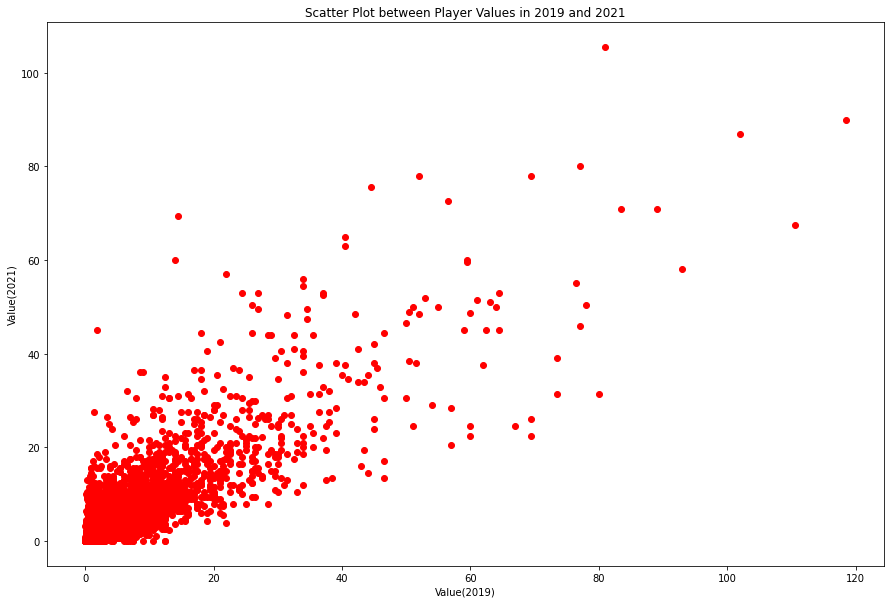

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

pd_df = regression_df.toPandas()

# plotting a scatter plot to see the realtionship between player values in 2019 and 2021
fig = plt.figure(figsize=(15,10))
plt.scatter(pd_df['Value_2019(M)'], pd_df['Value_2021(M)'], color='r')
plt.xlabel('Value(2019)')
plt.ylabel('Value(2021)')
plt.title('Scatter Plot between Player Values in 2019 and 2021')
plt.show()

There is a linear relationship between values in two years, and we can see some anomalies as well.

### 3.1 Data Preparation

We try to predict the value of players in two years using the attributes that might impact players' price tags and values.
***

Function:

Feature Engineering:

In this step, we try to find the features that are most correlated with the target (Gain in Two Years). From this step, we will only pick up those attributes who have at least of 10% correlation with the target whether negative or positive. We use both spearman and pearson correlation to determine this. Any attribute that pass this criterion on any of those two tests will be accepted into the next step.

In [27]:
from pyspark.ml.feature import VectorAssembler

features_col = [ 'Value_2021(M)', 'Age', 'Value_2019(M)', 'wage(K)', 'International Reputation', 'Height(CM)', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Acceleration', 'SprintSpeed', 'Agility', 
                      'Reactions', 'Balance', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'Overall_2019']

vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
df_class = vec_assembler.transform(regression_df).select('features')
df_class.show(5)

+--------------------+
|            features|
+--------------------+
|[67.5,31.0,110.5,...|
|[46.0,33.0,77.0,4...|
|[90.0,26.0,118.5,...|
|[87.0,27.0,102.0,...|
|[58.0,27.0,93.0,3...|
+--------------------+
only showing top 5 rows



In [28]:
regression_df[features_col].show(5)

+-------------+---+-------------+-------+------------------------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+------------+
|Value_2021(M)|Age|Value_2019(M)|wage(K)|International Reputation|Height(CM)|Weight(KG)|Crossing|Finishing|HeadingAccuracy|ShortPassing|Volleys|Dribbling|Curve|FKAccuracy|LongPassing|BallControl|Acceleration|SprintSpeed|Agility|Reactions|Balance|ShotPower|Jumping|Stamina|Strength|LongShots|Aggression|Interceptions|Positioning|Vision|Penalties|Composure|Marking|StandingTackle|SlidingTackle|Overall_2019|
+-------------+---+-------------+-------+------------------------+----------+----------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----

In [29]:
from pyspark.ml.stat import Correlation
#r1 = Correlation.corr(df_class, 'features', method='pearson').head()
pearson_corr = Correlation.corr(df_class, 'features', 'pearson').collect()[0][0]
print(str(pearson_corr))
#print('Pearson correlation matrix:\n' + str(r1[0]))

DenseMatrix([[ 1.        , -0.02770739,  0.85782914, ...,  0.08731344,
               0.06946364,  0.56321327],
             [-0.02770739,  1.        ,  0.08332409, ...,  0.20606472,
               0.1774763 ,  0.45704163],
             [ 0.85782914,  0.08332409,  1.        , ...,  0.09897944,
               0.07406407,  0.63777141],
             ...,
             [ 0.08731344,  0.20606472,  0.09897944, ...,  1.        ,
               0.96660681,  0.26505528],
             [ 0.06946364,  0.1774763 ,  0.07406407, ...,  0.96660681,
               1.        ,  0.22502964],
             [ 0.56321327,  0.45704163,  0.63777141, ...,  0.26505528,
               0.22502964,  1.        ]])


In [30]:
# alternative way to calculate pearson correlation
import six
for i in regression_df[features_col].columns:
  # checking if the instance is of string type and using six to write compatible code for both python2.x and 3.x
  if not(isinstance(regression_df[features_col].select(i).take(1)[0][0], six.string_types)):
    print('Correlation to Value_2021(M) for ', i, regression_df[features_col].stat.corr('Value_2021(M)',i, 'pearson'))

Correlation to Value_2021(M) for  Value_2021(M) 1.0
Correlation to Value_2021(M) for  Age -0.027707394939826924
Correlation to Value_2021(M) for  Value_2019(M) 0.8578291413547301
Correlation to Value_2021(M) for  wage(K) 0.6871367407656495
Correlation to Value_2021(M) for  International Reputation 0.5061458600475492
Correlation to Value_2021(M) for  Height(CM) 0.016467063896789525
Correlation to Value_2021(M) for  Weight(KG) 0.03158107549541299
Correlation to Value_2021(M) for  Crossing 0.2866238438200078
Correlation to Value_2021(M) for  Finishing 0.2605724384026795
Correlation to Value_2021(M) for  HeadingAccuracy 0.1872636149201672
Correlation to Value_2021(M) for  ShortPassing 0.4184740045460058
Correlation to Value_2021(M) for  Volleys 0.28333113158540485
Correlation to Value_2021(M) for  Dribbling 0.3655571634607507
Correlation to Value_2021(M) for  Curve 0.3046190864218007
Correlation to Value_2021(M) for  FKAccuracy 0.25385950867001567
Correlation to Value_2021(M) for  LongPass

In [31]:
# creating a datafame from the dense matrix
import pandas as pd

labels = features_col 
#creating a dataframe from the dense matrix
pearson_df = pd.DataFrame(pearson_corr.toArray(), index = [i for i in labels], columns = [i for i in labels])
pearson_df

,Value_2021(M),Age,Value_2019(M),wage(K),International Reputation,Height(CM),Weight(KG),Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Overall_2019
Value_2021(M),1.000000,-0.027707,0.857829,0.687137,0.506146,0.016467,0.031581,0.286624,0.260572,0.187264,0.418474,0.283331,0.365557,0.304619,0.253860,0.311748,0.443295,0.201222,0.206534,0.197761,0.484908,0.113784,0.305394,0.075775,0.237617,0.078977,0.287624,0.154577,0.111360,0.294273,0.340133,0.224936,0.430534,0.110445,0.087313,0.069464,0.563213
Age,-0.027707,1.000000,0.083324,0.147143,0.257786,0.034791,0.216236,0.264051,0.145055,0.344698,0.307773,0.244909,0.105670,0.259670,0.306941,0.306181,0.252234,-0.205127,-0.197892,-0.014238,0.456704,-0.091420,0.305241,0.187817,0.224108,0.359905,0.272781,0.397279,0.280574,0.189634,0.239894,0.249726,0.469837,0.233899,0.206065,0.177476,0.457042
Value_2019(M),0.857829,0.083324,1.000000,0.857582,0.658800,0.024735,0.063187,0.307121,0.295208,0.238121,0.461729,0.337592,0.382817,0.340615,0.301870,0.354520,0.481344,0.173487,0.174622,0.197519,0.554811,0.107327,0.351352,0.103629,0.258625,0.119220,0.331899,0.197143,0.134055,0.325437,0.380261,0.279781,0.499742,0.129472,0.098979,0.074064,0.637771
wage(K),0.687137,0.147143,0.857582,1.000000,0.669772,0.034371,0.082407,0.286224,0.245937,0.249402,0.414034,0.298813,0.329633,0.305859,0.266180,0.321273,0.426720,0.113060,0.119359,0.151289,0.505131,0.076448,0.320703,0.110943,0.211890,0.131756,0.292895,0.211978,0.156390,0.280841,0.331681,0.257917,0.460434,0.147690,0.124624,0.105531,0.577682
International Reputation,0.506146,0.257786,0.658800,0.669772,1.000000,0.031382,0.094443,0.263194,0.223769,0.244356,0.366966,0.310462,0.278352,0.303722,0.276803,0.300436,0.369862,0.026645,0.024692,0.097346,0.455615,0.047601,0.311654,0.106159,0.119417,0.127001,0.277217,0.210858,0.143661,0.253562,0.312008,0.285490,0.443133,0.134907,0.107710,0.089109,0.503091
Height(CM),0.016467,0.034791,0.024735,0.034371,0.031382,1.000000,0.389303,-0.257750,-0.145824,0.294405,-0.101514,-0.126293,-0.243338,-0.207104,-0.179702,-0.101760,-0.151227,-0.295821,-0.218334,-0.340024,0.007137,-0.431444,-0.050383,0.022022,-0.049343,0.344989,-0.155465,0.137542,0.089526,-0.206554,-0.194755,-0.108688,0.020093,0.105350,0.103304,0.087486,0.060618
Weight(KG),0.031581,0.216236,0.063187,0.082407,0.094443,0.389303,1.000000,-0.253189,-0.127819,0.522550,-0.071146,-0.086292,-0.278062,-0.198119,-0.156038,-0.083972,-0.133045,-0.414224,-0.311858,-0.495199,0.119793,-0.647471,0.052404,0.107841,0.029534,0.727302,-0.100514,0.321246,0.182635,-0.185965,-0.202406,-0.060165,0.119175,0.191196,0.182973,0.156786,0.185425
Crossing,0.286624,0.264051,0.307121,0.286224,0.263194,-0.257750,-0.253189,1.000000,0.413573,-0.135119,0.632644,0.472616,0.712890,0.716034,0.619132,0.593206,0.683383,0.439971,0.393444,0.547783,0.461856,0.435351,0.458524,-0.027594,0.351512,-0.176722,0.548852,0.105875,0.126635,0.585557,0.644715,0.371653,0.470053,0.088071,0.086104,0.079624,0.496591
Finishing,0.260572,0.145055,0.295208,0.245937,0.223769,-0.145824,-0.127819,0.413573,1.000000,0.002354,0.397742,0.814534,0.706552,0.613396,0.536832,0.218261,0.645211,0.373790,0.349441,0.481593,0.349369,0.311220,0.702877,-0.057662,0.119002,-0.125564,0.802591,-0.200801,-0.491597,0.819379,0.655078,0.745105,0.411945,-0.502248,-0.558260,-0.585836,0.372765
HeadingAccuracy,0.187264,0.344698,0.238121,0.249402,0.244356,0.294405,0.522550,-0.135119,0.002354,1.000000,0.133048,0.062462,-0.133505,-0.091835,-0.076077,0.057872,0.070801,-0.336139,-0.239271,-0.351510,0.407164,-0.467881,0.190815,0.357258,0.161807,0.641699,0.030432,0.458635,0.286643,-0.023310,-0.078500,0.109355,0.346528,0.274799,0.257301,0.234819,0.467578


Attributes that fail to satisfy the criterion from the pearson test are height(cm), weight(kg), crossing, dribbling, acceleration, sprint speed, agility, balance, jumping, stamina, strength, interceptions, marking, standing tackle and sliding tackle.

In [32]:
# creating a dataframe based on the spearman correlation
spearman_corr = Correlation.corr(df_class, 'features', 'spearman').collect()[0][0]
spearman_df = pd.DataFrame(spearman_corr.toArray(), index = [i for i in labels], columns = [i for i in labels])
spearman_df

,Value_2021(M),Age,Value_2019(M),wage(K),International Reputation,Height(CM),Weight(KG),Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Overall_2019
Value_2021(M),1.000000,-0.031378,0.852911,0.616682,0.320234,0.018145,0.042882,0.391831,0.336049,0.264642,0.573712,0.339630,0.544638,0.383999,3.050288e-01,0.425783,0.630050,0.283449,0.300918,0.278653,0.594043,0.134347,0.436190,0.115608,0.323502,0.120975,0.400749,0.221337,2.012557e-01,0.410170,0.423714,0.286102,0.537944,0.181707,0.189402,0.161119,0.736222
Age,-0.031378,1.000000,0.231094,0.334480,0.268063,0.055577,0.223385,0.290206,0.156343,0.357558,0.310933,0.252197,0.140607,0.271619,3.038601e-01,0.312917,0.265100,-0.127902,-0.112156,0.028833,0.479882,-0.072572,0.339442,0.232837,0.291573,0.377519,0.303410,0.415708,3.124447e-01,0.239529,0.259726,0.246365,0.475939,0.264212,0.245920,0.219029,0.480980
Value_2019(M),0.852911,0.231094,1.000000,0.772021,0.389602,0.050085,0.118722,0.477807,0.415332,0.384919,0.693919,0.439109,0.616439,0.482930,4.053561e-01,0.537003,0.744082,0.263435,0.283599,0.311696,0.769080,0.119048,0.571445,0.199892,0.432679,0.251933,0.519177,0.355802,2.892386e-01,0.514837,0.535376,0.372171,0.717101,0.254781,0.252667,0.209610,0.936872
wage(K),0.616682,0.334480,0.772021,1.000000,0.401885,0.051890,0.123141,0.422553,0.340516,0.377258,0.577342,0.388469,0.494325,0.424884,3.614060e-01,0.452557,0.613872,0.134672,0.152432,0.216585,0.670949,0.066129,0.497334,0.192885,0.325151,0.253610,0.445290,0.350599,2.789709e-01,0.432336,0.446747,0.347812,0.628725,0.242134,0.247475,0.212508,0.793917
International Reputation,0.320234,0.268063,0.389602,0.401885,1.000000,0.038529,0.099149,0.270247,0.212304,0.234937,0.367075,0.278096,0.284361,0.287528,2.496700e-01,0.308814,0.358218,0.024574,0.024530,0.094433,0.417354,0.049071,0.334086,0.123250,0.124442,0.139122,0.288676,0.233360,1.742434e-01,0.263818,0.300652,0.258393,0.419697,0.157131,0.148569,0.126916,0.439964
Height(CM),0.018145,0.055577,0.050085,0.051890,0.038529,1.000000,0.530650,-0.304192,-0.165098,0.403945,-0.132352,-0.158216,-0.284660,-0.256276,-2.374639e-01,-0.123920,-0.183924,-0.374939,-0.273359,-0.435822,0.007320,-0.570699,-0.053159,0.058853,-0.065388,0.506010,-0.173364,0.186022,1.362339e-01,-0.211042,-0.231375,-0.135294,0.020910,0.156654,0.164599,0.136737,0.067064
Weight(KG),0.042882,0.223385,0.118722,0.123141,0.099149,0.530650,1.000000,-0.231116,-0.111530,0.526319,-0.073164,-0.088467,-0.252942,-0.191950,-1.691041e-01,-0.073704,-0.123586,-0.392698,-0.285472,-0.471030,0.117305,-0.634769,0.063621,0.143869,0.024156,0.721054,-0.080012,0.321264,2.054623e-01,-0.139818,-0.189132,-0.060939,0.115193,0.219120,0.221535,0.190744,0.176246
Crossing,0.391831,0.290206,0.477807,0.422553,0.270247,-0.304192,-0.231116,1.000000,0.382331,-0.121629,0.619648,0.460440,0.697100,0.707600,6.100146e-01,0.570590,0.672943,0.451486,0.409914,0.529829,0.475300,0.413912,0.468827,-0.011435,0.382261,-0.177244,0.534594,0.112616,1.466893e-01,0.551418,0.623248,0.357482,0.474868,0.099990,0.102671,0.107060,0.515703
Finishing,0.336049,0.156343,0.415332,0.340516,0.212304,-0.165098,-0.111530,0.382331,1.000000,0.017743,0.363167,0.813244,0.690492,0.587632,5.235825e-01,0.192678,0.626822,0.378769,0.355991,0.462088,0.349026,0.292872,0.690493,-0.050877,0.117522,-0.116566,0.780261,-0.190788,-4.720628e-01,0.821689,0.613399,0.751012,0.396163,-0.498034,-0.538022,-0.567660,0.374860
HeadingAccuracy,0.264642,0.357558,0.384919,0.377258,0.234937,0.403945,0.526319,-0.121629,0.017743,1.000000,0.122471,0.048592,-0.111208,-0.092524,-8.819589e-02,0.061870,0.072667,-0.321094,-0.220789,-0.342045,0.390993,-0.464468,0.205938,0.380576,0.155508,0.659633,0.051143,0.464795,3.318644e-01,0.029467,-0.072339,0.098704,0.340613,0.324002,0.328199,0.298971,0.463664

Attributes that fail to satisfy the criterion from the spearman test are height(cm), acceleration, sprint speed, agility, balance and sliding tackle.

Based on the above two tests, we remove height(cm), acceleration, sprint speed, agility, balance and sliding tackle from the prediction analysis in further steps.

In [33]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

def steps_processor(features_col, df):

  # creating a feature vector
  vec_assembler = VectorAssembler(inputCols=features_col, outputCol='features')
  df_class = vec_assembler.transform(df).select('features','Value_2021(M)')

  # scaling the feature vector
  standardscaler = StandardScaler().setInputCol('features').setOutputCol('Scaled_features')
  raw_data = standardscaler.fit(df_class).transform(df_class)

  # splitting the dataset
  train, test = raw_data.randomSplit([0.7, 0.3], seed=2020)
  return train, test

In [34]:
features_col = ['Age', 'Value_2019(M)', 'wage(K)', 'International Reputation', 'Weight(KG)', 
                      'Crossing', 'Finishing', 'HeadingAccuracy', 
                      'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                      'FKAccuracy', 'LongPassing', 'BallControl', 
                      'Reactions', 'ShotPower', 'Jumping', 
                      'Stamina', 'Strength', 'LongShots', 'Aggression', 
                      'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'Composure', 'Marking', 'StandingTackle', 'Overall_2019']
train, test = steps_processor(features_col, regression_df)

In [35]:
test.show()

+--------------------+-------------+--------------------+
|            features|Value_2021(M)|     Scaled_features|
+--------------------+-------------+--------------------+
|[17.0,1.100000023...|         0.95|[3.74211125958050...|
|[17.0,1.700000047...|        0.925|[3.74211125958050...|
|[17.0,1.799999952...|         45.0|[3.74211125958050...|
|[17.0,3.5,8.0,1.0...|          9.0|[3.74211125958050...|
|[17.0,3.5,25.0,1....|         10.0|[3.74211125958050...|
|[17.0,17.5,66.0,1...|         27.5|[3.74211125958050...|
|[18.0,1.0,2.0,1.0...|          1.6|[3.96223545132053...|
|[18.0,1.100000023...|          3.9|[3.96223545132053...|
|[18.0,1.100000023...|          1.1|[3.96223545132053...|
|[18.0,1.200000047...|         12.5|[3.96223545132053...|
|[18.0,1.200000047...|         0.85|[3.96223545132053...|
|[18.0,1.799999952...|          1.4|[3.96223545132053...|
|[18.0,2.200000047...|          2.0|[3.96223545132053...|
|[18.0,2.200000047...|         10.0|[3.96223545132053...|
|[18.0,2.59999

Next, we compare three baseline models and select the best baseline model for further tuning in the later step.

In [48]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='Scaled_features', labelCol='Value_2021(M)', maxIter=10)
model_lr = lr.fit(train)
predict_train_lr = model_lr.transform(train)
print("Coefficients: " + str(model_lr.coefficients))
print("Intercept: " + str(model_lr.intercept))

Coefficients: [-0.70334956340292,4.945193336170726,-0.8295088216949118,-0.275094219812215,0.02243552671062238,0.1591098709330165,0.037468201326869205,0.06494541082052493,0.04683563902771925,-0.07879608341236036,0.11151848432417819,0.07175592432436503,-0.05266551697298419,-0.14873857316459915,0.039489250011819486,0.10973638334783643,0.07471289819730048,-0.01841733057296531,-0.04751822902447317,0.021027110823241553,-0.0875115367632867,-0.07304345391685128,-0.05096775049953453,-0.0023372642063383426,0.05600342235703434,-0.0797323216984514,0.0610796655985248,-0.0081181284886554,0.19101117768141143,0.47577485739879977]
Intercept: -1.69765234010574


From the coefficient values, it is seen that some attributes have positive while some have negative relationship with the players value in 2021. Also, when all the attributes are not passed to the model, then the value of a player is determined to be -1.698 million.

In [49]:
training_summary = model_lr.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)
print("r2: %f" % training_summary.r2)
print("MAE: %f" % training_summary.meanAbsoluteError)

RMSE: 2.559508
r2: 0.761439
MAE: 1.202181


We are using both RMSE and MAE since MAE is robust to outliers and RMSE is not. As we saw previously in the visualisation that our data has some outliers too, so using both these metrics is useful. To note, we are not seeing the effect of outliers too much in our data from these two metrics.

In [50]:
# finding the mean, min and max to compare RMSE, MAE and measure performance
train.describe().show()

+-------+------------------+
|summary|     Value_2021(M)|
+-------+------------------+
|  count|             11204|
|   mean|2.5537435737236707|
| stddev|5.2405381631664785|
|    min|               0.0|
|    max|             105.5|
+-------+------------------+



R square value of 0.7614, which is 76.14% variability in players' value in 2021 is explained using the above attributes and remaining 13.8% variability could be defined through other attributes, seems good. And our RMSE of 2.56 considering the min, max and mean is not that bad. However, this result is for training set, we still need to see how our model performs for the test set.

In [51]:
from pyspark.ml.evaluation import RegressionEvaluator

predict_test_lr = model_lr.transform(test)
predict_test_lr.select('prediction','Value_2021(M)','features').show(5)
lr_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
print('R2 on test data = %g' % lr_evaluator.evaluate(predict_test_lr))

+------------------+-------------+--------------------+
|        prediction|Value_2021(M)|            features|
+------------------+-------------+--------------------+
|2.6570310065593006|         0.95|[17.0,1.100000023...|
| 2.900587662037924|        0.925|[17.0,1.700000047...|
|  3.70742702778392|         45.0|[17.0,1.799999952...|
|  4.88091083903083|          9.0|[17.0,3.5,8.0,1.0...|
| 4.588769718268651|         10.0|[17.0,3.5,25.0,1....|
+------------------+-------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.763502


In [52]:
test_result = model_lr.evaluate(test)
print('RMSE on test data = %g' % test_result.rootMeanSquaredError)
print('MAE on test data = %g' % test_result.meanAbsoluteError)

RMSE on test data = 2.64606
MAE on test data = 1.17752


In our test set, the model's predictibility has improved to 76.35% from 76.14%, but the RMSE error has increased by 0.09 from 2.56 to 2.65. At the same time, our mean absolute error has decreased by around 0.02. Overall, this is neither a bad performance nor huge improvement when the model is used on the test set.

Performing Ridge Regression:


In [54]:
from pyspark.ml.regression import LinearRegression

lr_ridge = LinearRegression(featuresCol='Scaled_features', labelCol='Value_2021(M)', maxIter=10, regParam=0.3, elasticNetParam=0)
model_lr_ridge = lr_ridge.fit(train)
predict_train_lr_ridge = model_lr_ridge.transform(train)
print("Coefficients: " + str(model_lr_ridge.coefficients))
print("Intercept: " + str(model_lr_ridge.intercept))

Coefficients: [-0.810399185424929,3.8607848079653673,-0.11289901524502634,-0.11730387536686042,0.016871487291112052,0.10863413099084065,0.06002929368168801,0.05633211533131794,0.05278520651885274,-0.051145364144713296,0.10237278999339983,0.04946889856606396,-0.018735299112969915,-0.10220180406839248,0.06550798169203041,0.18270728741364678,0.029116547251262417,-0.023675446082823706,0.010185711148439735,0.023980445723532865,-0.08045310022342343,-0.07617746671251892,-0.04261479302845867,-0.00371477959442127,0.04828974344980392,-0.09736091172823529,0.08024128742609077,0.013690142003357577,0.108877562606142,0.5885754713196231]
Intercept: -3.2764133551611865


In [58]:
training_summary = model_lr_ridge.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)
print("r2: %f" % training_summary.r2)
print("MAE: %f" % training_summary.meanAbsoluteError)

RMSE: 2.606366
r2: 0.752624
MAE: 1.217410


In [62]:
from pyspark.ml.evaluation import RegressionEvaluator

predict_test_lr_ridge = model_lr_ridge.transform(test)
predict_test_lr_ridge.select('prediction','Value_2021(M)','features').show(5)
lr_ridge_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
print('R2 on test data = %g' % lr_ridge_evaluator.evaluate(predict_test_lr_ridge))

+------------------+-------------+--------------------+
|        prediction|Value_2021(M)|            features|
+------------------+-------------+--------------------+
| 3.036225343749474|         0.95|[17.0,1.100000023...|
|3.3535419453550652|        0.925|[17.0,1.700000047...|
|3.7359576967733696|         45.0|[17.0,1.799999952...|
| 4.966393015754652|          9.0|[17.0,3.5,8.0,1.0...|
| 5.120041337869034|         10.0|[17.0,3.5,25.0,1....|
+------------------+-------------+--------------------+
only showing top 5 rows

R2 on test data = 0.75218


In [57]:
test_result_ridge = model_lr_ridge.evaluate(test)
print('RMSE on test data = %g' % test_result_ridge.rootMeanSquaredError)
print('MAE on test data = %g' % test_result_ridge.meanAbsoluteError)

RMSE on test data = 2.70866
MAE on test data = 1.20645


It is seen that the ordinary least square regression produced better results than the ridge regression at aplahe = 0.3 with low RMSE and MAE for the ordinary least square compared to ridge regression.

Performing Lasso Regression:


In [60]:
from pyspark.ml.regression import LinearRegression

lr_lasso = LinearRegression(featuresCol='Scaled_features', labelCol='Value_2021(M)', maxIter=10, regParam=0.3, elasticNetParam=1)
model_lr_lasso = lr_lasso.fit(train)
predict_train_lr_lasso = model_lr_lasso.transform(train)
print("Coefficients: " + str(model_lr_lasso.coefficients))
print("Intercept: " + str(model_lr_lasso.intercept))

Coefficients: [-0.36724550029181113,3.9234657987345214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0041225568387910855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.35628886635407214]
Intercept: -0.6979756680662363


In [61]:
training_summary = model_lr_lasso.summary
print("RMSE: %f" % training_summary.rootMeanSquaredError)
print("r2: %f" % training_summary.r2)
print("MAE: %f" % training_summary.meanAbsoluteError)

RMSE: 2.668219
r2: 0.740743
MAE: 1.153230


In [63]:
from pyspark.ml.evaluation import RegressionEvaluator

predict_test_lr_lasso = model_lr_lasso.transform(test)
predict_test_lr_lasso.select('prediction','Value_2021(M)','features').show(5)
lr_lasso_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Value_2021(M)', metricName='r2')
print('R2 on test data = %g' % lr_lasso_evaluator.evaluate(predict_test_lr_lasso))

+------------------+-------------+--------------------+
|        prediction|Value_2021(M)|            features|
+------------------+-------------+--------------------+
| 2.168554405639531|         0.95|[17.0,1.100000023...|
| 2.631027097657568|        0.925|[17.0,1.700000047...|
|2.7519074771886425|         45.0|[17.0,1.799999952...|
| 4.020324976423087|          9.0|[17.0,3.5,8.0,1.0...|
| 4.020794947517447|         10.0|[17.0,3.5,25.0,1....|
+------------------+-------------+--------------------+
only showing top 5 rows

R2 on test data = 0.743619


In [64]:
test_result_lasso = model_lr_lasso.evaluate(test)
print('RMSE on test data = %g' % test_result_lasso.rootMeanSquaredError)
print('MAE on test data = %g' % test_result_lasso.meanAbsoluteError)

RMSE on test data = 2.75504
MAE on test data = 1.13878


Compared to ordinary regression and ridge regression, the MAE has improved while RMSE has worsen a bit at alpha = 0.3. This may be due to the fact that RMSE penalises large error differences caused by anomalies. If we don't like large error differences caused by anomalies then we should use RMSE or if we don't care about large difference MAE is suitable. 

We will go with MAE on this one and consider lasso regression is better than all.